In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys # filesystem operations
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from argparse import Namespace
import matplotlib.pyplot

In [54]:
img_size=32

In [55]:
def fiximg(orig_img):
    size0=orig_img.size[0]
    size1=orig_img.size[1]
    desired_size=(img_size, img_size)
    #if size0 != size1:
    #    if size0<size1:
    #        desired_size=(size0,size0)
    #    else:
    #        desired_size=(size1,size1)
    old_size = orig_img.size
    new_size = (desired_size[0],desired_size[1])
    padded_image = Image.new("RGB", new_size, color="white")
    padded_image.paste(orig_img, ((new_size[0] - old_size[0]) // 2, (new_size[1] - old_size[1]) // 2))
    orig_img=padded_image
    return orig_img

5519
(32, 32, 3)


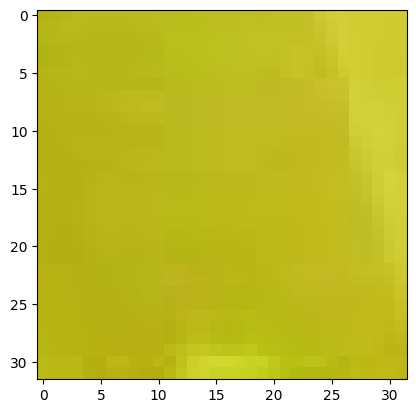

In [56]:
#how to get a random flower
input_dir = '.'
#dataset_dir = os.path.join(input_dir,'UnstableNetGen/notebooks/102flowers')
dataset_dir='102flowers/jpg/'
random_number = np.random.randint(1, 8190)
print(random_number)
img_name='image_0'+str(random_number).zfill(4)+'.jpg'
imgpath=os.path.join(dataset_dir,img_name)
orig_img = Image.open(imgpath)
orig_img=fiximg(orig_img)
print(np.shape(orig_img))
plt.imshow(orig_img)
plt.show()

In [57]:

class DS():
    def __init__(self,min, max):
        self.min=min
        self.max=max
        self.dataset_dir = os.path.join(input_dir,'102flowers/jpg/')
        random_number = np.random.randint(1, 8190)
        
    def __len__(self):
        return self.max-self.min
    def __getitem__(self, idx):
        #class_id = torch.as_tensor(self.categories.index(self.labels[idx]), dtype=torch.int64)
        number=idx+self.min
        img_name='image_0'+str(number).zfill(4)+'.jpg'
        imgpath=os.path.join(self.dataset_dir,img_name)
        orig_img = Image.open(imgpath)
        orig_img=fiximg(orig_img)
        shaper=np.shape(orig_img)
        img=np.reshape(orig_img, (shaper[0]*shaper[1]*shaper[2], -1))/255.0
        return torch.tensor(img).T
train_data=DS(1, 8000)
print(train_data[0].shape)
test_data=DS(8001, 8190)

torch.Size([1, 3072])


In [58]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense_layer1 = nn.Linear(in_features=img_size*img_size*3, out_features=512)
        #self.dense_layer2 = nn.Linear(in_features=2056, out_features=1024)
        #self.dense_layer3 = nn.Linear(in_features=1024, out_features=512)
        self.dense_layer4 = nn.Linear(in_features=512, out_features=256)
        self.dense_layer5 = nn.Linear(in_features=256, out_features=128)
        self.dense_layer6 = nn.Linear(in_features=128, out_features=108)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        #x = F.leaky_relu(self.dense_layer2(x))
        #x = F.leaky_relu(self.dense_layer3(x))
        x = F.leaky_relu(self.dense_layer4(x))
        x = F.leaky_relu(self.dense_layer5(x))
        x = F.leaky_relu(self.dense_layer6(x))
        return x

In [59]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_layer001 = nn.Linear(in_features=108, out_features=128)
        self.dense_layer01 = nn.Linear(in_features=128, out_features=256)
        self.dense_layer1 = nn.Linear(in_features=256, out_features=512)
        #self.dense_layer2 = nn.Linear(in_features=512, out_features=1024)
        #self.dense_layer3 = nn.Linear(in_features=1024, out_features=2056)
        self.dense_layer4 = nn.Linear(in_features=512, out_features=img_size*img_size*3)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer001(x))
        x = F.leaky_relu(self.dense_layer01(x))
        x = F.leaky_relu(self.dense_layer1(x))
        #x = F.leaky_relu(self.dense_layer2(x))
        #x = F.leaky_relu(self.dense_layer3(x))
        x = F.leaky_relu(self.dense_layer4(x))
        return x

In [60]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
myEncoder=Encoder()
myDecoder=Decoder()

In [61]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
myModel = Autoencoder(myEncoder, myDecoder)
myModel = myModel.to(device)
train_dl=torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

In [62]:
def training(model, train_dl, num_epochs, iteration):
    # Loss Function, Optimizer and Scheduler  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)#01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs)

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs = data[0].to(device)
            inputs = inputs.to(torch.float32)
            #print(labels.is_cuda)
            #print(np.shape(inputs))
            # Normalize the inputs
            #inputs_m, inputs_s = inputs.mean(), inputs.std()
            #inputs = (inputs - inputs_m) / inputs_s
            #print(inputs.is_cuda)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #print(outputs.is_cuda)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
        print(running_loss)
        print(epoch)
for i in range(1):
    num_epochs=60
    iteration=i
    training(myModel, train_dl, num_epochs, iteration)
    #trainingacclist.append(trainacc)
    
    #temp1, temp2, testacc=inference(myModel, test_dl)
    #testacclist.append(testacc)
#x_axis = list(range(1, len(testacclist) + 1))
#plt.plot(x_axis, trainingacclist, x_axis, testacclist)

111.17170836706646
0
43.355612292536534
1


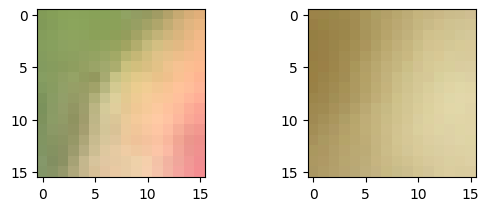

In [ ]:
for i, data in enumerate(test_dl):
    # Get the input features and target labels, and put them on the GPU
    inputs = data[0].to(device)
    inputs = inputs.to(torch.float32)
    break

orig=inputs.reshape(img_size,img_size, 3)
output=myEncoder(inputs)

output=myDecoder(output)
#print(output)
output=output.detach().cpu().numpy()
output=output.reshape(img_size,img_size,3)
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(orig)
matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.imshow(output)